In [1]:
import pandas as pd

In [2]:
train = pd.read_json('./data/train.json')

In [6]:
test = pd.read_json('./data/test.json')

In [5]:
train.count(), test.count()

band_1        1604
band_2        1604
id            1604
inc_angle     1604
is_iceberg    1604
dtype: int64

In [8]:
id, band_1, band_2 = test.iloc[0][['id', 'band_1', 'band_2']]

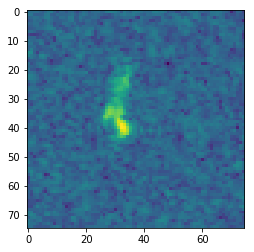

In [53]:
record = np.array(train[train.id == '0c4dee0f'].iloc[0].band_2)
record = (record - record.min()) / (record.max() - record.min()) * 255
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
plt.imshow(np.array(record).reshape(75, 75))

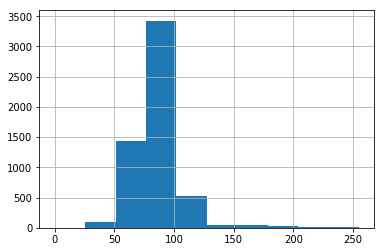

In [54]:
pd.Series(record).hist()

In [324]:
size = 75
def prep_image(data):
    data = np.array(data)
    data = (data - np.min(data)) / (np.max(data) - np.min(data)) ** 2
    return data.reshape(size, size)[25:50, 25:50].reshape(-1)

preX_1 = np.concatenate(train.band_1.apply(lambda data: prep_image(data)).values).reshape(-1, 25 * 25)
preX_2 = np.concatenate(train.band_2.apply(lambda data: prep_image(data)).values).reshape(-1, 25 * 25)
preX_3 = np.hstack([preX_1, preX_2])
X = np.concatenate(preX_3).reshape(-1, 25 * 25 * 2)
y = train.is_iceberg

In [327]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
model = KNeighborsClassifier(n_neighbors=25, weights='distance')
# model = RandomForestClassifier()
model = SVC(probability=True)
scores = cross_val_score(model, X, y, scoring='neg_log_loss', cv=3)
scores, scores.mean(), scores.std()

(array([-0.63506092, -0.6083279 , -0.64137134]),
 -0.62825338502060479,
 0.014323039588076979)

In [317]:
report = pd.DataFrame({'y_pred': cross_val_predict(model, X, y, method='predict_proba')[:, 1], 'y_true': y, 'id': train.id })
report['diff'] = np.absolute(report.y_pred - report.y_true)

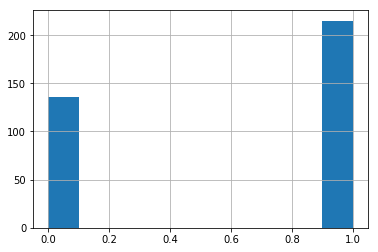

In [271]:
report[report['diff'] >= 0.5].sort_values(by='diff', ascending=False)['y_pred'].round(0).hist()